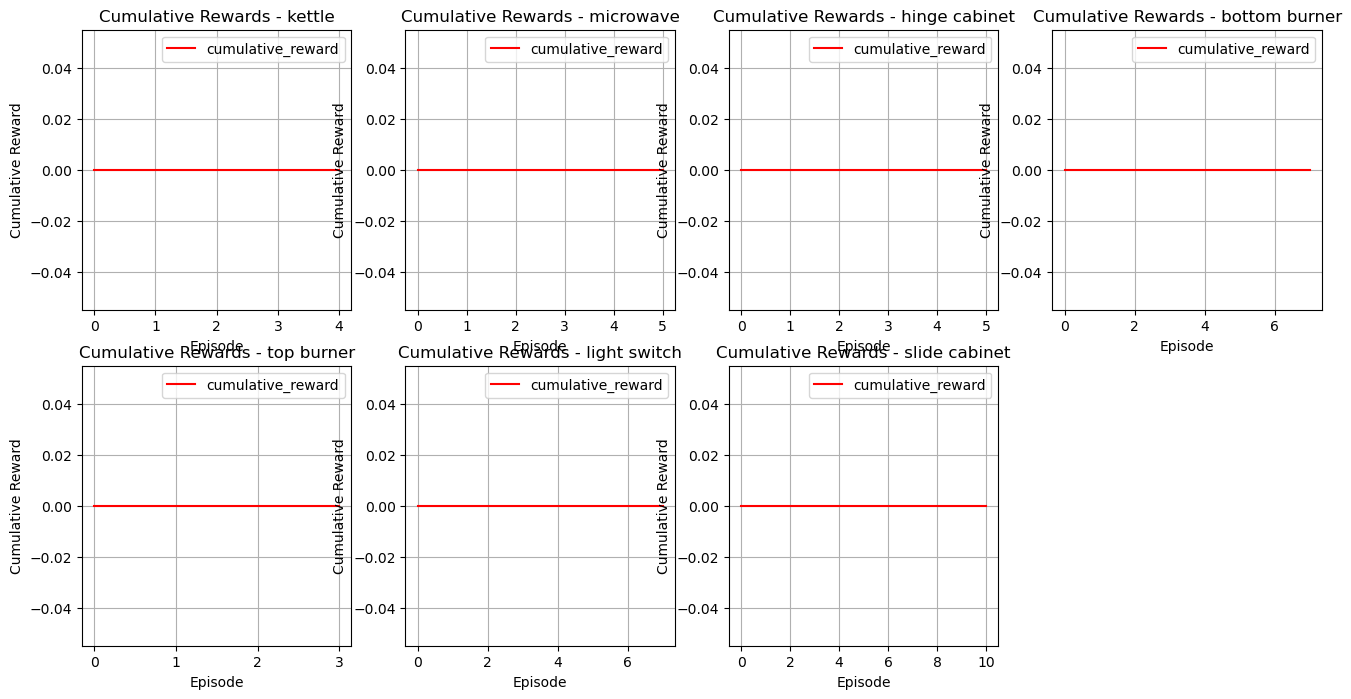

--> Starting fresh training.
Episode 0 | Steps 300 | Buffer 1500
Episode 10 | Steps 3300 | Buffer 16500
Episode 20 | Steps 6300 | Buffer 31500
Episode 30 | Steps 9300 | Buffer 46500
Episode 40 | Steps 12300 | Buffer 61500


KeyboardInterrupt: 

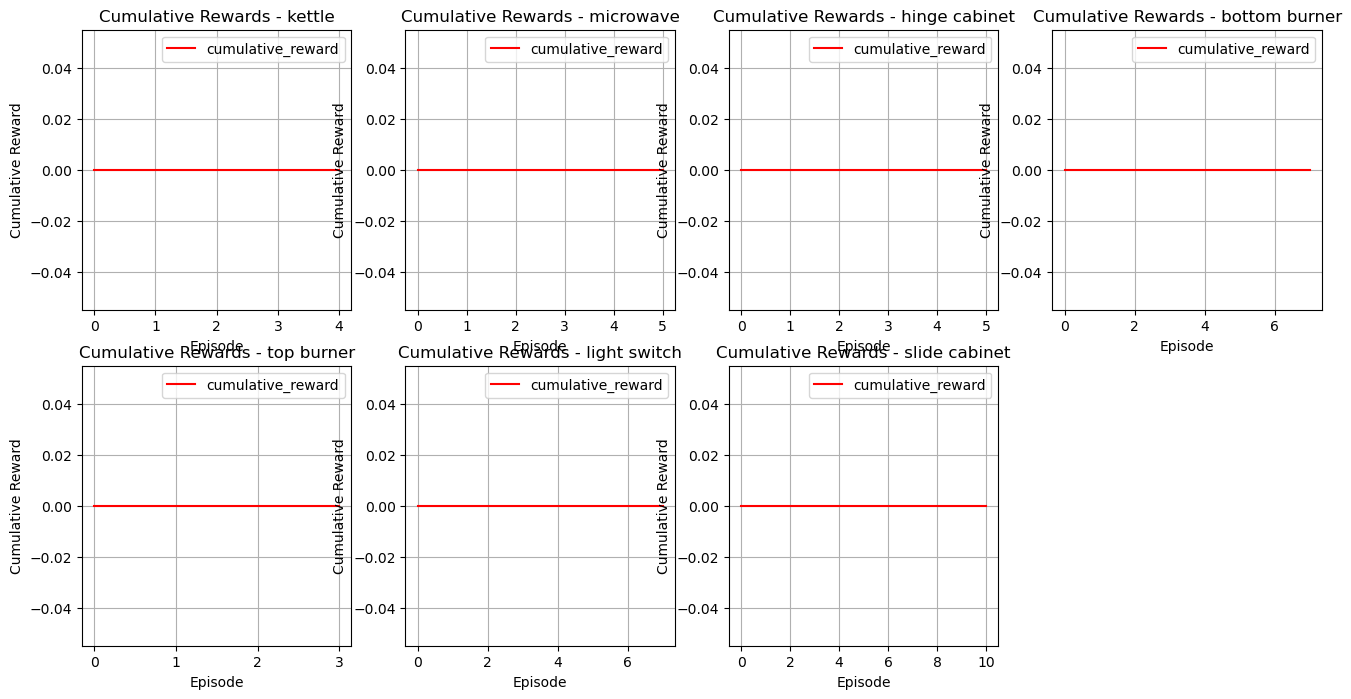

In [ ]:
import torch
import numpy as np
import gymnasium as gym
import gymnasium_robotics
import random
import os
from utils.agent import DDPGAgent
from utils.training import train_agent
from utils.replay_buffer import ReplayBuffer

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 

NUM_EPISODES = 5000
START_STEPS = 25000
BATCH_SIZE = 20000
NUM_ACTIONS = 9
GOAL_DIM = 4
STATE_DIM = 59
MAX_STEPS = 300
DEVICE = "cuda"

TASKS = ['kettle',
         'microwave',
         'hinge cabinet',
         'bottom burner',
         'top burner',
         'light switch',
         'slide cabinet']

TASKS = [
         'slide cabinet',
         'microwave']

TASK_LENGTHS = {
    "kettle": 7,
    "microwave": 1,
    "hinge cabinet": 2,
    "slide cabinet": 1,
    "bottom burner": 2,
    "top burner": 2,
    "light switch": 2
}

TASK_LENGTHS = {
    "slide cabinet": 1,
    "microwave": 1,
}


gym.register_envs(gymnasium_robotics)

env = gym.make(id='FrankaKitchen-v1', 
               max_episode_steps=MAX_STEPS,
               tasks_to_complete=TASKS)

env.action_space.seed(SEED)

agent = DDPGAgent(STATE_DIM,
                  NUM_ACTIONS,
                  GOAL_DIM,
                  DEVICE
                  )

replay_buffer = ReplayBuffer(STATE_DIM,
                             NUM_ACTIONS,
                             GOAL_DIM,
                             DEVICE,
                             max_size=100_000)


train_agent(env,
            agent,
            replay_buffer,
            TASKS,
            TASK_LENGTHS,
            NUM_EPISODES,
            BATCH_SIZE,
            START_STEPS,
            her_ratio = 2,
            reward_threshold = 1e-1)